In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from pandas.tseries.offsets import BDay
seaborn.set()

# Asijská opce mean reverting model

 ### Příprava dat

In [2]:
raw_data = pd.read_csv("datasets/CLN20.NYM.csv")
data1 = raw_data.set_index(raw_data.columns[0])

contract_raw = data1.iloc[:,3]
contract_raw = contract_raw["2019-05-06":"2020-03-08"]
contract_raw.index = pd.to_datetime(contract_raw.index)
contract_raw = contract_raw.asfreq(BDay())
contract_raw = contract_raw.fillna(method='ffill').dropna()
contract_raw.tail()

pct_ch = contract_raw.pct_change()
contract = pd.DataFrame({"contract":contract_raw,"%change":pct_ch}, index=contract_raw.index).dropna()
contract["logreturn"] = np.log(contract_raw/contract_raw.shift(1))
contract["delta"] = contract_raw - contract_raw.shift(1)
contract["shifted_contract"] = contract_raw.shift()

contract.tail()

,contract,%change,logreturn,delta,shifted_contract
Date,,,,,
2020-03-02,45.230000,-0.048791,-0.050021,-2.319999,47.549999
2020-03-03,47.139999,0.042229,0.041361,1.909999,45.230000
2020-03-04,47.520000,0.008061,0.008029,0.380001,47.139999
2020-03-05,47.220001,-0.006313,-0.006333,-0.299999,47.520000
2020-03-06,46.340000,-0.018636,-0.018812,-0.880001,47.220001


### Odhadnutí průměru posledních hodnot

In [3]:
c1 = data1.iloc[:,3]
c1 = c1["2019-07-29":]#"2020-03-08"]
c1.index = pd.to_datetime(c1.index)
c1 = c1.asfreq(BDay())
c1 = c1.fillna(method='ffill').dropna()
c1_delta = c1 - c1.shift()
c1_all = pd.DataFrame({"contract":c1,"delta":c1_delta}, index=c1.index).dropna()
c1_all.tail()

,contract,delta
Date,,
2020-04-03,33.000000,3.879999
2020-04-06,32.799999,-0.200001
2020-04-07,32.040001,-0.759998
2020-04-08,33.470001,1.430000
2020-04-09,32.029999,-1.440002


Text(0.5, 0, 'Cena [ $/barel ]')

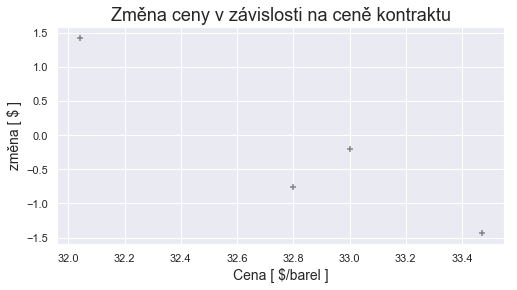

In [4]:
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(c1_all["contract"].shift().tail(4), c1_all["delta"].tail(4), c="k", marker="+", alpha=0.5)
ax.set_ylabel("změna [ $ ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
#fig.savefig('mean%re.pdf', format='pdf', bbox_inches='tight')

Pro odhadnutý průměr vyberu posledních 5 hodnot, protože v předchozím grafu není poslední hodnota (graf je závislost změny ceny na výchozí hodnotě)

In [5]:
c1[-5:]

Date
2020-04-03    33.000000
2020-04-06    32.799999
2020-04-07    32.040001
2020-04-08    33.470001
2020-04-09    32.029999
Freq: B, Name: Close, dtype: float64

In [6]:
estimated_average = c1[-5:].mean()
estimated_average

32.668

Grafy pro dataset

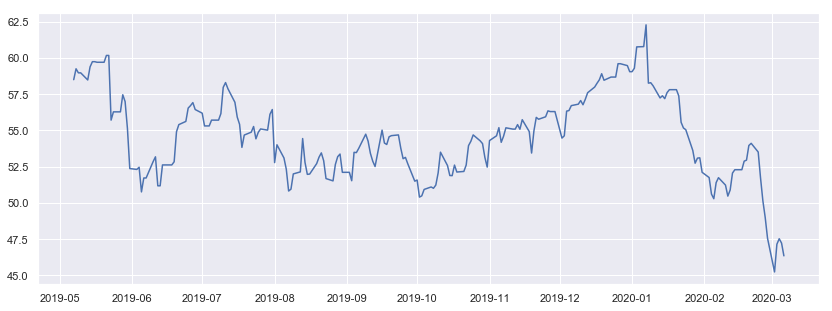

In [7]:
plt.figure(figsize=(14,5))
plt.plot(contract.iloc[:,0])
#plt.plot(contract.iloc[:,4], "--")

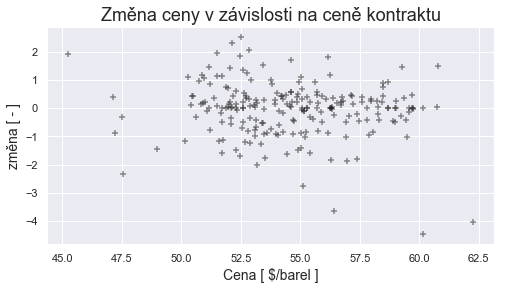

In [8]:

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(contract["shifted_contract"], contract["delta"], c="k", marker="+", alpha=0.5)
ax.set_ylabel("změna [ - ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('CLN20.NYM_scatter.pdf', format='pdf', bbox_inches='tight')

In [9]:
import statsmodels.api as sm


Regrese s %change [ - ] jako závislou proměnnou a výchozí hodnotou jako nezávislou proměnnou

In [10]:
y4 = contract["%change"]
X4 = sm.add_constant(contract["shifted_contract"])

res4 = sm.OLS(y4,X4).fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                %change   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.399
Date:                Sat, 02 May 2020   Prob (F-statistic):             0.0666
Time:                        22:42:58   Log-Likelihood:                 575.48
No. Observations:                 219   AIC:                            -1147.
Df Residuals:                     217   BIC:                            -1140.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0401      0.022      1.797      0.074      -0.004       0.084
shifted_contract    -0.0008      0.000     -1.844      0.067      -0.002    5.19e-05
==============================================================================
Omnibus:                       29.892   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.472
Skew:                          -0.707   Prob(JB):                     9.00e-13
Kurtosis:                       5.020   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
print(res4.params)
print("a = ", res4.params[0])
print("b = ", res4.params[1])
print(f"kappa = {-res4.params[1]}")
print(f"mean = {-res4.params[0]/res4.params[1]}")
print(f"volatility = {res4.resid.std()}")

const               0.040070
shifted_contract   -0.000752
dtype: float64
a =  0.0400695502684801
b =  -0.0007519668597503032
kappa = 0.0007519668597503032
mean = 53.28632472152499
volatility = 0.017520048871918614


Regrese s rozdílem mezi 2 cenami = delta [ $ ] jako závislou proměnnou a výchozí hodnotou jako nezávislou proměnnou

In [12]:
y1 = contract["delta"]
X1 = sm.add_constant(contract["shifted_contract"])

res1 = sm.OLS(y1,X1).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.734
Date:                Sat, 02 May 2020   Prob (F-statistic):             0.0546
Time:                        22:42:58   Log-Likelihood:                -300.45
No. Observations:                 219   AIC:                             604.9
Df Residuals:                     217   BIC:                             611.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2885      1.217      1.880      0.061      -0.110       4.687
shifted_contract    -0.0430      0.022     -1.932      0.055      -0.087       0.001
==============================================================================
Omnibus:                       42.454   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.554
Skew:                          -0.891   Prob(JB):                     6.55e-22
Kurtosis:                       5.741   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
print(res1.params)
print("a = ", res1.params[0])
print("b = ", res1.params[1])
print(f"kappa = {-res1.params[1]}")
print(f"mean = {-res1.params[0]/res1.params[1]}")
print(f"volatility = {res1.resid.std()}")

const               2.288466
shifted_contract   -0.043018
dtype: float64
a =  2.2884657556582324
b =  -0.04301778742728949
kappa = 0.04301778742728949
mean = 53.198127856443
volatility = 0.956241960107404


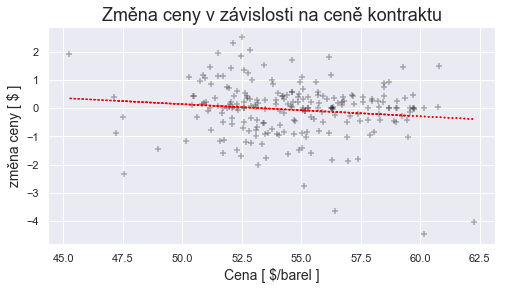

In [14]:
yhat1 = res1.params[0] + res1.params[1] * contract["shifted_contract"]

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(contract["shifted_contract"], contract["delta"], c="black", marker="+", alpha=0.3 )
ax.plot(contract["shifted_contract"], yhat1, linestyle=":", color="red")
ax.set_ylabel("změna ceny [ $ ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('lin_reg_normal.pdf', format='pdf', bbox_inches='tight')

In [15]:
reshc3 = res1.get_robustcov_results(cov_type="HC3")
reshc3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     2.054
Date:                Sat, 02 May 2020   Prob (F-statistic):              0.153
Time:                        22:42:59   Log-Likelihood:                -300.45
No. Observations:                 219   AIC:                             604.9
Df Residuals:                     217   BIC:                             611.7
Df Model:                           1                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                2.2885      1.634      1.401      0.163      -0.931       5.508
shifted_contract    -0.0430      0.030     -1.433      0.153      -0.102       0.016
==============================================================================
Omnibus:                       42.454   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.554
Skew:                          -0.891   Prob(JB):                     6.55e-22
Kurtosis:                       5.741   Cond. No.                     1.03e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.03e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
print("a = ", reshc3.params[0])
print("b = ", reshc3.params[1])
print(f"kappa = {-reshc3.params[1]}")
print(f"mean = {-reshc3.params[0]/reshc3.params[1]}")
print(f"volatility = {reshc3.resid.std()}")

a =  2.2884657556582324
b =  -0.04301778742728949
kappa = 0.04301778742728949
mean = 53.198127856443
volatility = 0.9540562613405268


### Testy 

In [17]:
from statsmodels.stats.diagnostic import het_white
white1 = het_white(res1.resid,X1)
white1

(13.728140906845393,
 0.001044653055055519,
 7.222807960571279,
 0.0009196286327566917)

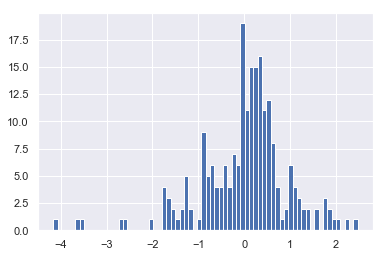

In [18]:
plt.hist(reshc3.resid,bins=70)
plt.show()

In [19]:
from auxiliary.distribution_fit import distribution_fit
par_res = distribution_fit(reshc3.resid)
par_res

Parameters are in this format: (location, scale)
(7.056760046932501e-16, 0.9540562613405268)
(3.0348509175121157, 0.09279858290198163, 0.6298759964470947)
(0.1508712568723723, 0.4087131039910995)
(7.035052240147503e-16, 0.6787701440271494)

The larger the p-value, the better
Normal:  0.0031355973867359986
Student t KstestResult(statistic=0.05868970896620346, pvalue=0.4255783579194845)
Cauchy:  KstestResult(statistic=0.06983868061591969, pvalue=0.22538950617407333)
Laplace:  KstestResult(statistic=0.10187354684551886, pvalue=0.019712199418560943)
TE  [7.056760046932501e-16, 0.9540562613405268, 0.0031355973867359986]


,Normal,T,Cauchy,Laplace
Loc,7.056760e-16,0.092799,0.150871,7.035052e-16
Scale,9.540563e-01,0.629876,0.408713,6.787701e-01
p (KSTest),3.135597e-03,0.425578,0.225390,1.971220e-02


In [20]:
from statsmodels.stats.stattools import jarque_bera
j1 = jarque_bera(reshc3.resid)
j1

(97.55357664392419,
 6.55405357019186e-22,
 -0.8912656547716096,
 5.741055462842779)

### Výpočet dnů do expirace

I tady je nutné změnit asian_may_20_settle na 2020-05-29 a přetypovat ze stringu na datetime pokud už je opce proexpirovaná

In [21]:
contract_raw_all = data1.iloc[:,3]
contract_raw_all = contract_raw_all["2019-05-06":]
contract_raw_all.index = pd.to_datetime(contract_raw_all.index)
contract_raw_all = contract_raw_all.asfreq(BDay())
contract_raw_all = contract_raw_all.fillna(method='ffill').dropna()
contract_raw_all.tail()

Date
2020-04-03    33.000000
2020-04-06    32.799999
2020-04-07    32.040001
2020-04-08    33.470001
2020-04-09    32.029999
Freq: B, Name: Close, dtype: float64

In [22]:
from auxiliary.ContractCalendar import ContractCalendar

raw_data_all = pd.read_csv("datasets/CLN20.NYM.csv")
data_all = raw_data_all.set_index(raw_data.columns[0])
print(data_all.index[-1])

asian_cal = ContractCalendar.wti_average_option()
asian_may_20 = asian_cal.calendar[asian_cal.calendar["Contract Month"]=="May 2020 WTI Average Price Option"]
asian_may_20_settle = asian_may_20.iloc[0,-1]
print(asian_may_20_settle)
averaging_days = ContractCalendar.get_business_days_in_month(end_of_month=asian_may_20_settle)
print(averaging_days)
print(len(averaging_days))
all_days = ContractCalendar.get_business_days(start=data_all.index[-1],end=asian_may_20_settle)
print(all_days)
print(len(all_days))


2020-04-09
2020-05-29 00:00:00
DatetimeIndex(['2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-18',
               '2020-05-19', '2020-05-20', '2020-05-21', '2020-05-22',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29'],
              dtype='datetime64[ns]', freq='B')
21
DatetimeIndex(['2020-04-09', '2020-04-10', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-20',
               '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-18',
               '2020-05-19', '2020-0

### Simulační výpočet

In [23]:
from simulations.simulations import asian_simulation_mean_reverting_final

In [24]:
pos = "p"
init_price = data_all.iloc[-1,3]
strike = 50
sim = 10000
steps = len(all_days)-1
avg_steps=len(averaging_days)
avg_values=[]
group = (0.093,0.63,3.035,"t")
mean_value = estimated_average
reversion_speed = 0.043

np.random.seed(19121995)

total,paths, payoffs = asian_simulation_mean_reverting_final(position_flag=pos,initial_price=init_price, strike=strike, simulations=sim, steps=steps,
                                avg_steps=avg_steps , avg_values=avg_values, group=group,
                                 mean_value=mean_value, reversion_speed=reversion_speed ,strike_type="fixed")
    
print(total)

161139.2093911127


Výpočet diskontované ceny

In [25]:
maturity = (len(all_days)-1)/252
discount_rate = 0.01
import numpy as np
(np.exp(-discount_rate*maturity)/sim)*total

16.090917487004766

In [26]:
(len(all_days)-1)

36

 Graf prvních 100 simulací

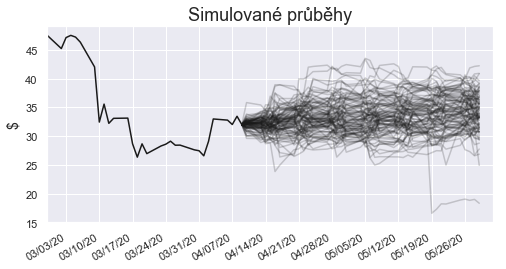

In [27]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title("Simulované průběhy", fontsize=18)
ax.plot(contract_raw_all.iloc[-30:],color="k")
for path in paths[:100]:
    ax.plot(all_days, path, color="k", alpha=0.2)
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(contract_raw_all.index[-30], all_days[-1]+BDay())
fig.autofmt_xdate()
plt.show()
fig.savefig('sim_asian_mean_reverting.pdf', format='pdf', bbox_inches='tight')

In [28]:
#paths[78]

Výpočet konfidenčního intervalu

In [29]:
s = pd.Series(payoffs)
s.std()

2.959992843956383

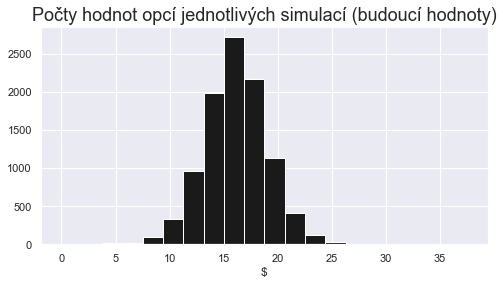

In [30]:
plt.figure(figsize=(8, 4))
plt.title("Počty hodnot opcí jednotlivých simulací (budoucí hodnoty)", fontsize=18)
plt.xlabel("$")
plt.hist(s, bins=20, color="k")
plt.plot()
plt.savefig('sim_asian_payoffs_mean_reverting.pdf', format='pdf', bbox_inches='tight')

In [31]:
se = s.std()/np.sqrt(sim)
se

0.02959992843956383